# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
profile.shape

(17000, 5)

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
transcript.shape

(306534, 4)

In [8]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# 1. Clean the data

In [9]:
# create helper function
def add_dummies(df, column_name):
    """
    add properly named dummy columns to a dataframe based on a column of this data frame;
    drops the original column
    args:
      df - the dataframe where to add the dummy column
      column_name - the name of the column with the values used for creation of the dummy values
    returns:
      dataframe with added dummy colmuns and drop original column
    
    """
    df = df.join(pd.get_dummies(df[column_name],prefix=column_name))
    df.drop(columns=column_name, inplace=True)
    return df

## 1.1 Dataframe "portfolio" 

In [10]:
#rename columns in portfolio df to fit the description
portfolio.rename(columns={"id": "offer_id", "reward": "offer_reward", "difficulty": "offer_difficulty", 
                          "channels": "offer_channels"}, inplace=True)

In [11]:
# convert duration to hours (from days) to match other time information and rename column accordingly
portfolio["duration"] *= 24
portfolio.rename(columns={"duration": "offer_duration_h"}, inplace=True)

In [12]:
# create better readable names for the offers
offers = {}
for i, offer in enumerate(np.unique(portfolio['offer_id'])):
    offers.update({offer: 'offer_{}'.format(i)})

In [13]:
# add offer name to portfolio
portfolio["offer_name"] = portfolio["offer_id"].map(offers)

In [14]:
portfolio.sort_values('offer_name')

,offer_reward,offer_channels,offer_difficulty,offer_duration_h,offer_type,offer_id,offer_name
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_0
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,offer_1
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5,offer_2
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,offer_3
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,offer_4
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837,offer_5
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_6
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,offer_7
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,offer_8
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,offer_9


In [15]:
# create dummy variables for offer_type column and drop original column
portfolio = add_dummies(portfolio,"offer_type")

In [16]:
# create dummy variables for channel column and drop original column 
#due to special layout the use of helper function is not possible
portfolio = portfolio.join(pd.get_dummies(portfolio["offer_channels"].explode(),prefix="offer_channel").sum(level=0))
portfolio.drop(columns="offer_channels", inplace=True)

In [17]:
portfolio.head()

,offer_reward,offer_difficulty,offer_duration_h,offer_id,offer_name,offer_type_bogo,offer_type_discount,offer_type_informational,offer_channel_email,offer_channel_mobile,offer_channel_social,offer_channel_web
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,offer_7,1,0,0,1,1,1,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,offer_4,1,0,0,1,1,1,1
2,0,0,96,3f207df678b143eea3cee63160fa8bed,offer_3,0,0,1,1,1,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_6,1,0,0,1,1,0,1
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_0,0,1,0,1,0,0,1


## 1.2 Dataframe "profile" 

In [18]:
#rename columns in profile df to fit the description
profile.rename(columns={"gender": "customer_gender", "age": "customer_age", "id": "customer_id", 
                        "income": "customer_income", "became_member_on": "customer_became_member_on"}, inplace=True)

### 1.2.1 customer_age

In [19]:
profile['customer_age'].min() #min age seems reasonable

18

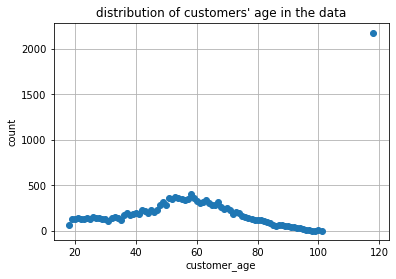

In [20]:
# plot median price per month
profile.groupby('customer_age')['customer_age'].count().plot(style='o')
plt.title("distribution of customers' age in the data")
plt.grid(True)
plt.ylabel('count')
plt.savefig('plots/age_distribution.png', dpi=600)

In [21]:
#customer_age = 118 seem to represent invalid values -> drop those rows
profile.drop(profile.loc[profile['customer_age']==118].index, inplace=True)

In [22]:
#check for nan values
profile.isnull().sum() #no further nan values

customer_gender              0
customer_age                 0
customer_id                  0
customer_became_member_on    0
customer_income              0
dtype: int64

In [23]:
##age groups, source for idea https://support.google.com/searchads/answer/7298369?hl=en

#for sanity reasons for the programmer; not needed for this data set
profile.loc[(profile['customer_age']<18),'customer_age'] = 0

#age group1: From 18 to 24
profile.loc[((profile['customer_age']>=18)&(profile['customer_age']<25)),'customer_age'] = 1
#age group2: From 25 to 34
profile.loc[((profile['customer_age']>=25)&(profile['customer_age']<35)),'customer_age'] = 2
#age group3: From 35 to 44
profile.loc[((profile['customer_age']>=35)&(profile['customer_age']<45)),'customer_age'] = 3
#age group4: From 45 to 54
profile.loc[((profile['customer_age']>=45)&(profile['customer_age']<55)),'customer_age'] = 4
#age group5: From 55 to 64
profile.loc[((profile['customer_age']>=55)&(profile['customer_age']<65)),'customer_age'] = 5
#age group6: From 65 to 74
profile.loc[((profile['customer_age']>=65)&(profile['customer_age']<75)),'customer_age'] = 6
#age group7: 75 and over
profile.loc[(profile['customer_age']>=75),'customer_age'] = 7

In [24]:
#prepare labels for age groups
age_groups = {'0': '<18',
             '1': '18-24',
             '2': '25-34',
             '3': '35-44',
             '4': '45-54',
             '5': '55-64',
             '6': '65-74',
             '7': '>75',}

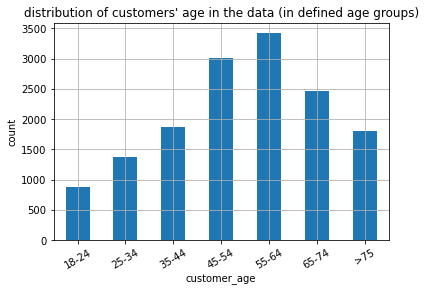

In [25]:
# plot age distribution (age groups)  
profile.groupby('customer_age')['customer_age'].count().plot(kind='bar')
plt.title("distribution of customers' age in the data (in defined age groups)")
plt.grid(True)
plt.ylabel('count')
#adjust x labels
locs, labels = plt.xticks();
for i in range(len(labels)):
    labels[i].set_text(age_groups[labels[i].get_text()])
plt.xticks(locs,labels,rotation=30)#rotation='horizontal')

plt.savefig('plots/age_distribution_age_groups.png', dpi=600, bbox_inches="tight")

### 1.2.2 customer_gender

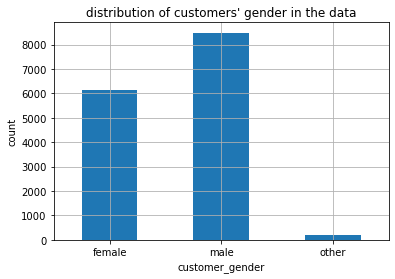

In [26]:
# plot gender distribution
profile.groupby('customer_gender')['customer_gender'].count().plot(kind='bar')
plt.title("distribution of customers' gender in the data")
plt.grid(True)
plt.ylabel('count')
plt.xticks((0, 1, 2), ('female', 'male', 'other'),rotation=0)
plt.savefig('plots/gender_distribution.png', dpi=600)

In [27]:
#create dummy columns for gender; drop the original column
profile = add_dummies(profile,"customer_gender")

### 1.2.3 customer_income

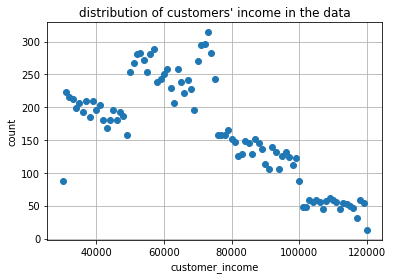

In [28]:
# plot income distribution
profile.groupby('customer_income')['customer_income'].count().plot(style='o')
plt.title("distribution of customers' income in the data")
plt.grid(True)
plt.ylabel('count')
plt.savefig('plots/income_distribution.png', dpi=600)

In [29]:
#set income to groups of 10k
profile['customer_income_10k'] = (profile['customer_income']/10000).astype('int')
profile.drop(columns="customer_income", inplace=True)

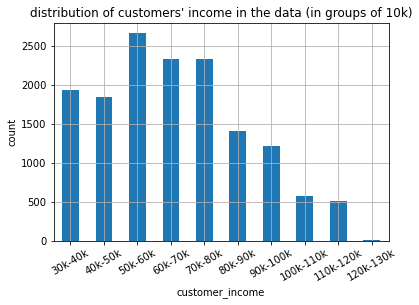

In [30]:
# plot income distribution (10k groups)  
profile.groupby('customer_income_10k')['customer_income_10k'].count().plot(kind='bar')
plt.title("distribution of customers' income in the data (in groups of 10k)")
plt.grid(True)
plt.ylabel('count')
#adjust x labels
locs, labels = plt.xticks();
for i in range(len(labels)):
    cat = int(labels[i].get_text())
    labels[i].set_text("{}k-{}k".format(cat*10,(cat+1)*10))
plt.xticks(locs,labels,rotation=30)
plt.xlabel('customer_income')
plt.savefig('plots/income_distribution10k.png', dpi=600, bbox_inches="tight")

### 1.2.4 customer_became_member_on

In [31]:
# convert to datetime and only extract year from became member on column
profile["customer_became_member_on"] = (pd.to_datetime(profile["customer_became_member_on"], format='%Y%m%d')).dt.year

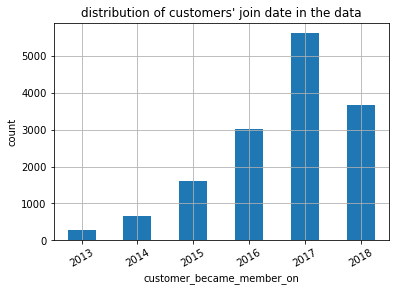

In [32]:
# plot became member on distribution
profile.groupby('customer_became_member_on')['customer_became_member_on'].count().plot(kind='bar')
plt.title("distribution of customers' join date in the data")
plt.grid(True)
plt.ylabel('count')
plt.xticks(rotation=30)
plt.savefig('plots/join_date_distribution.png', dpi=600, bbox_inches="tight")

In [33]:
#final layout of profile dataframe
profile.head()

,customer_age,customer_id,customer_became_member_on,customer_gender_F,customer_gender_M,customer_gender_O,customer_income_10k
1,5,0610b486422d4921ae7d2bf64640c50b,2017,1,0,0,11
3,7,78afa995795e4d85b5d9ceeca43f5fef,2017,1,0,0,10
5,6,e2127556f4f64592b11af22de27a7932,2018,0,1,0,7
8,6,389bc3fa690240e798340f5a15918d5c,2018,0,1,0,5
12,5,2eeac8d8feae4a8cad5a6af0499a211d,2017,0,1,0,5


## 1.3 Dataframe "transcript" 

In [34]:
#rename columns in transcript df to fit the description
transcript.rename(columns={"person": "customer_id","time":"time_h"}, inplace=True)

In [35]:
# extract offer id in value column and add to transcript df
transcript_ID_extract = pd.DataFrame(transcript['value'].values.tolist())
transcript['offer_id'] = transcript_ID_extract['offer_id'].fillna(transcript_ID_extract['offer id'])

In [36]:
#drop original value column
transcript.drop(columns='value', inplace=True)

In [37]:
# transaction events are not relevant -> drop them
transcript = transcript[(transcript["event"] != 'transaction')]

In [38]:
transcript[transcript['offer_id'].isnull()].shape #all entries have an offer_id

(0, 4)

In [39]:
np.unique(transcript['event']) # there is only offer ... recieved, viewed and completed

array(['offer completed', 'offer received', 'offer viewed'], dtype=object)

In [40]:
#create shorter description
transcript.loc[(transcript['event'] == 'offer received'),'event_short'] = '1'
transcript.loc[(transcript['event'] == 'offer viewed'),'event_short'] = '2'
transcript.loc[(transcript['event'] == 'offer completed'),'event_short'] = '3'

In [41]:
transcript.head()

,customer_id,event,time_h,offer_id,event_short
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,1
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,1


In [42]:
#sort chronologically 
transcript_grouped = transcript.sort_values(by=['time_h','event_short'], ascending=True) 

In [43]:
#combine events by customer and offer
transcript_grouped = transcript_grouped.groupby(['customer_id', 'offer_id'])['event_short'].apply(''.join)
transcript_grouped = transcript_grouped.reset_index()  

In [44]:
# calculate offer success rate = share of offers that are vieved and completed from offers send out
transcript_grouped['offer_recieved'] = transcript_grouped['event_short'].str.count("1")
transcript_grouped['offer_viewed_completed'] = transcript_grouped['event_short'].str.count("23")
transcript_grouped['offer_success_rate'] = transcript_grouped['offer_viewed_completed']/transcript_grouped['offer_recieved']

In [45]:
#map better readbale offer names to offer ids
transcript_grouped["offer_name"] = transcript_grouped["offer_id"].map(offers)

In [46]:
transcript_grouped.head()

,customer_id,offer_id,event_short,offer_recieved,offer_viewed_completed,offer_success_rate,offer_name
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,13,1,0,0.0,offer_2
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,12,1,0,0.0,offer_3
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,12,1,0,0.0,offer_5
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,132,1,0,0.0,offer_8
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,132,1,0,0.0,offer_9


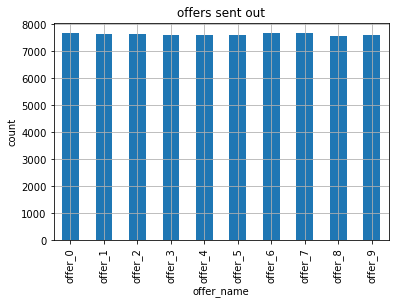

In [47]:
# plot offers send out
transcript_grouped.groupby(['offer_name'])['offer_recieved'].sum().plot(kind='bar')
plt.title("offers sent out")
plt.grid(True)
plt.ylabel('count')
plt.savefig('plots/offers_sent.png', dpi=600, bbox_inches="tight")

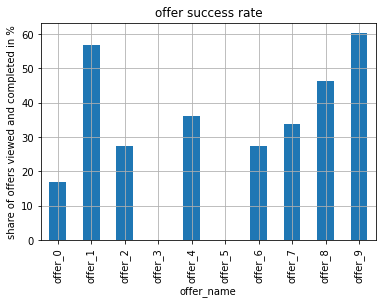

In [48]:
# plot success rate
(100*transcript_grouped.groupby(['offer_name'])['offer_viewed_completed'].sum()
 /transcript_grouped.groupby(['offer_name'])['offer_recieved'].sum()).plot(kind='bar')
plt.title("offer success rate")
plt.grid(True)
plt.ylabel('share of offers viewed and completed in %')
plt.savefig('plots/offers_success_rate.png', dpi=600, bbox_inches="tight")

In [49]:
# offers 3 and 5 are informational offers -> 0% success rate is ok

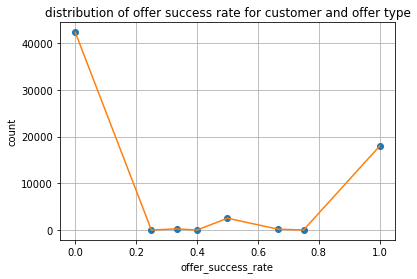

In [50]:
# plot frequemce of offer_success_rate (the value we want to predict)
transcript_grouped.groupby(['offer_success_rate'])['offer_success_rate'].count().plot(style='o')
transcript_grouped.groupby(['offer_success_rate'])['offer_success_rate'].count().plot()
plt.title("distribution of offer success rate for customer and offer type")
plt.grid(True)
plt.ylabel('count')
plt.savefig('plots/offers_success_rate_by_customer_and_offer_type.png', dpi=600, bbox_inches="tight")

# 2. Prepare the data

In [51]:
#create master dataframe by merging all three dataframes
master = transcript_grouped.merge(portfolio.drop(columns='offer_name'), on='offer_id')
master = master.merge(profile, on='customer_id')

In [52]:
#drop not needed rows (=informational offers)
master = master[(master["offer_name"] != 'offer_3') & (master["offer_name"] != 'offer_5')]

In [53]:
#drop not needed columns
master.drop(columns=['event_short', 'offer_recieved', 'offer_viewed_completed', 
                     'customer_id', 'offer_id', 'offer_name'], inplace=True)

In [54]:
master.shape

(44181, 17)

In [55]:
master.head()

,offer_success_rate,offer_reward,offer_difficulty,offer_duration_h,offer_type_bogo,offer_type_discount,offer_type_informational,offer_channel_email,offer_channel_mobile,offer_channel_social,offer_channel_web,customer_age,customer_became_member_on,customer_gender_F,customer_gender_M,customer_gender_O,customer_income_10k
0,0.0,2,10,168,0,1,0,1,1,0,1,2,2017,0,1,0,7
3,0.0,5,5,120,1,0,0,1,1,1,1,2,2017,0,1,0,7
4,0.0,2,10,240,0,1,0,1,1,1,1,2,2017,0,1,0,7
5,0.0,2,10,168,0,1,0,1,1,0,1,1,2016,1,0,0,6
7,1.0,2,10,240,0,1,0,1,1,1,1,1,2016,1,0,0,6


# 3. Create machine learning model(s)

In [56]:
#define features and output variable
X = master.drop(columns=['offer_success_rate'])
y = master['offer_success_rate']

In [57]:
# plit into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
# init scaler and regressors
scaler = StandardScaler()

linReg = LinearRegression()
knr = KNeighborsRegressor()
svr = SVR()
br = BayesianRidge()

In [59]:
#scale test / train sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [60]:
# Train the LinearRegression model using the training set and predict
linReg.fit(X_train, y_train)
y_pred_linReg = linReg.predict(X_test)

In [61]:
# Train the KNeighborsRegressor model using the training set and predict
knr.fit(X_train, y_train)
y_pred_knr = knr.predict(X_test)

In [62]:
# Train the SVR model using the training set and predict
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

In [63]:
# Train the BayesianRidge model using the training set and predict
br.fit(X_train, y_train)
y_pred_br = br.predict(X_test)

# 4. Evaluate results

In [64]:
#calculate RMSE for LinearRegression model
mean_squared_error(y_test, y_pred_linReg, squared=False)

0.4395458405498139

In [65]:
#calculate Coefficient of Determination (R^2) for LinearRegression model
r2_score(y_test, y_pred_linReg)

0.15521976068640309

In [66]:
#calculate RMSE for KNeighborsRegressor model
mean_squared_error(y_test, y_pred_knr, squared=False)

0.46790606196105244

In [67]:
#calculate Coefficient of Determination (R^2) for KNeighborsRegressor model
r2_score(y_test, y_pred_knr)

0.04268968012144625

In [68]:
#calculate RMSE for SVR model
mean_squared_error(y_test, y_pred_svr, squared=False)

0.4571939240587259

In [69]:
#calculate Coefficient of Determination (R^2) for SVR model
r2_score(y_test, y_pred_svr)

0.08602083124181759

In [70]:
#calculate RMSE for BayesianRidge model
mean_squared_error(y_test, y_pred_br, squared=False)

0.43954674437429964

In [71]:
#calculate Coefficient of Determination (R^2) for BayesianRidge model
r2_score(y_test, y_pred_br)

0.15521628649199615